In [1]:
import propagation_methods as propag
import grid_generation as grid
import bounds_common as bounds
import barriers as barriers
import probability_mass_computation as proba
import plot_methods as plot

import numpy as np

### **The linear bimodal case** 

In this experiement, $x_0$ follows a GMM with two components, and the system is linear $f(x_t) = Ax_{t}$, where $A$ is known. We assume $\varepsilon_t$ to be normally distributed, with a fixed stationary covariance, i.e. $\varepsilon_t \sim \mathcal{N}([0, 0], \Sigma_{\varepsilon})$.

We aim to compute GMM approximations $\hat{p}(x_t)$ for $10$ time steps, as well as bounds on their TV distances to the true distributions $p(x_t)$.

**Numerical note**: The theory related to this experiement does NOT demand that those Gaussians should have uncorrelated components. However, our current code implementation does assume that.

##### 1) Defining system parameters

In [2]:
METHOD = 'linear'

A = np.array(
          [
              [0.84, 0.1],
              [0.05, 0.72]
          ])

params = [A]

In [3]:
#Initial distribution
initial_weights = [0.5, 0.5]
sigma = 0.005

mean_initial_state_mode1 = np.array([8, 10])
var_initial_state = np.array([sigma, sigma]) #Assumes uncorrelation (this could be relaxed in further upgrades)

mean_initial_state_mode2 = np.array([6, 10])

#Noise structure
sigma_noise = 0.03

mean_noise = [0, 0]
var_noise = np.array([sigma_noise, sigma_noise]) #Assumes uncorrelation (this could be relaxed in further upgrades)

#Steps ahead for prediction
n_steps_ahead = 10

In [4]:
unbounded_region = np.array([[np.inf, np.inf], [np.inf, np.inf]]) #a representation choice for the unbounded region

In [5]:
colors = ['Purples', 'Blues', 'Oranges', 'YlOrBr', 'YlOrRd', 
          'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 
          'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

##### 2) Monte Carlo simulation of the system

We run a MC simulation for the system above in order to understand its (probabilistic) behavior.

Note: We also add a representation for an unsafe set (red square) which will later motivate safety discussions.

In [6]:
barriers_list = barriers.createBarrier(np.array([[3.5, 2], [4.5, 3]]))
barrier = barriers_list[0]

In [7]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

C:\Users\efigueiredomot\AppData\Local\Temp\ipykernel_3584\2522582876.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0011
Hitting proba: 0.184
Hitting proba: 0.3882
Hitting proba: 0.211
Hitting proba: 0.0336
Hitting proba: 0.0019
Hitting proba: 0.0002


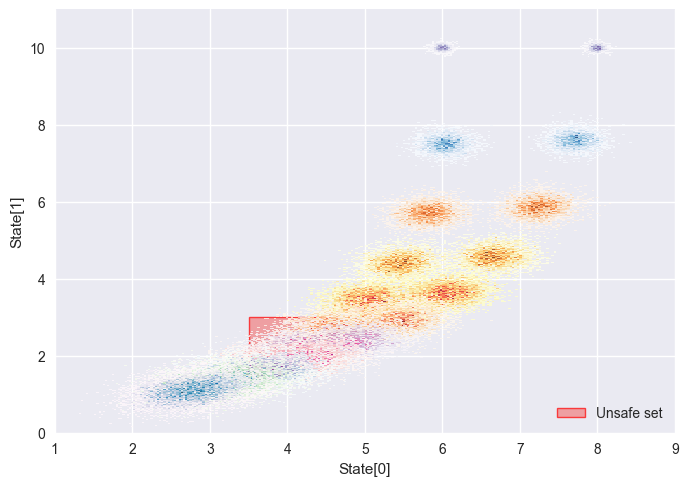

In [8]:
from matplotlib.patches import Rectangle

n_simulations = 10_000
mc_hitting_proba = []

fig, ax = plt.subplots()

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

for t in range(n_steps_ahead + 1):
    if t == 0:
        mean_initial = [mean_initial_state_mode1, mean_initial_state_mode2]
        states = []
        for n in range(n_simulations):
            index_normal = np.random.choice(2, p = initial_weights)
            state = propag.getInitialState(mean_initial[index_normal], var_initial_state, 1)
            states.append(state)
        states = np.array(states)
        
    else:
        states = propag.stateOneStepEvolution(states, mean_noise, var_noise, METHOD, params)
    
    #Plot samples
    plt.hist2d(states[:, 0], states[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    #Compute hitting probability
    hitting_proba = barriers.hittingProbabilityMC(states, barrier)
    mc_hitting_proba.append(hitting_proba)

plt.legend(loc='lower right')

plt.xlim(1, 9)
plt.ylim(0, 11)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

##### Computing TV bounds

Function 'computeSignatureProbabilitiesInParallel' executed in 0.7128s
TV bound at propag step: 0.08223074871556275
Function 'computeSignatureProbabilitiesInParallel' executed in 0.8519s
Number of regions:  1043
TV bound at propag step: 0.04175010122328822
Function 'computeSignatureProbabilitiesInParallel' executed in 0.8430s
Number of regions:  4073
TV bound at propag step: 0.02099290809169247
Function 'computeSignatureProbabilitiesInParallel' executed in 0.9838s
Number of regions:  15776
TV bound at propag step: 0.010546275764601232
Function 'computeSignatureProbabilitiesInParallel' executed in 1.2298s
Number of regions:  59378
TV bound at propag step: 0.005339452811432854
Function 'computeSignatureProbabilitiesInParallel' executed in 1.3187s
Number of regions:  90383
TV bound at propag step: 0.003743095724142464
0.0
Function 'computeSignatureProbabilitiesInParallel' executed in 1.0549s
TV bound at propag step: 0.1404916589321598
Function 'computeSignatureProbabilitiesInParallel' exe

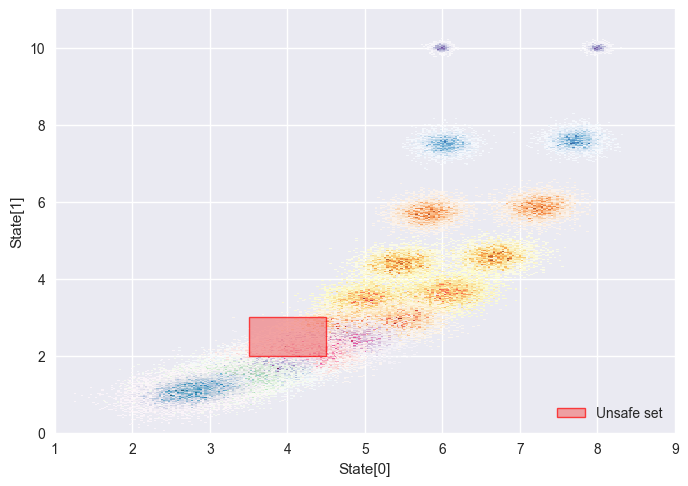

In [9]:
n_samples = 10_000

min_proportion = 0.01
min_size = 0.01
n_refinements = 5

tv_bounds = [0.0]
gmm_hitting_proba = [0.0]


fig, ax = plt.subplots()

for t in range(n_steps_ahead + 1):

    if t == 0:
        hat_gmm = [np.array(initial_weights), np.array([mean_initial_state_mode1, mean_initial_state_mode2]), var_initial_state]
    else:
        means_gmm = propag.propagateSignatures(signatures, METHOD, params)
        hat_gmm = [double_hat_proba, means_gmm, var_noise]

        #Compute hitting probability
        proba_barrier = proba.gmmProbabilityMassInsideRegion(double_hat_proba, means_gmm, var_noise, barrier)
        gmm_hitting_proba.append(proba_barrier)


    samples = propag.sampleFromGMM(n_samples, hat_gmm[0], hat_gmm[1], hat_gmm[2])
    plt.hist2d(samples[:, 0], samples[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    if t < n_steps_ahead:

        vertice_lower, vertice_upper = grid.findMinMaxPoints(samples)

        hpr = np.array([vertice_lower, vertice_upper])

        outer_signature = grid.computeOuterPoint(hpr)

        regions = np.array(grid.subdivideRegion(hpr, samples, min_proportion, min_size))

        signatures = grid.placeSignatures(regions)

        double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])

        regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)

        tv_bound, contributions = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)

        for r in range(n_refinements):

            regions, signatures = grid.refineRegions(regions, signatures, contributions, 1e-7)
            regions = regions[:-1]
            signatures = signatures[:-1]
            double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])
            regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)
            print('Number of regions: ', len(regions))

            tv_bound, contributions = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)

        tv_bounds.append(tv_bound)
    

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

plt.legend(loc='lower right')

plt.xlim(1, 9)
plt.ylim(0, 11)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

##### TV contribution per region

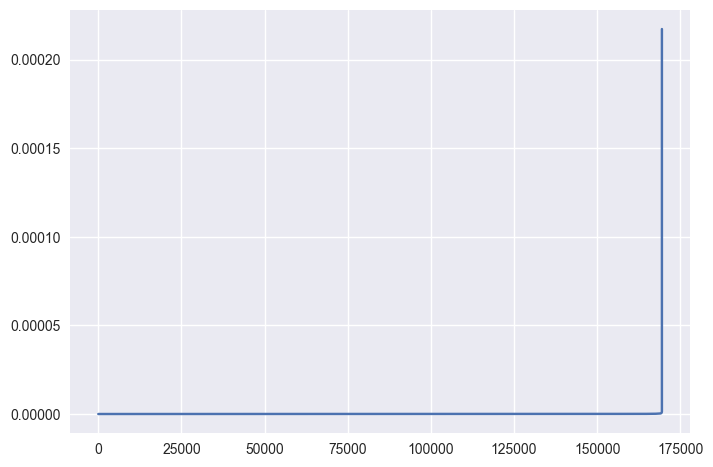

In [10]:
contributions = np.array(contributions)
contributions = np.sort(contributions)
plt.plot(contributions)

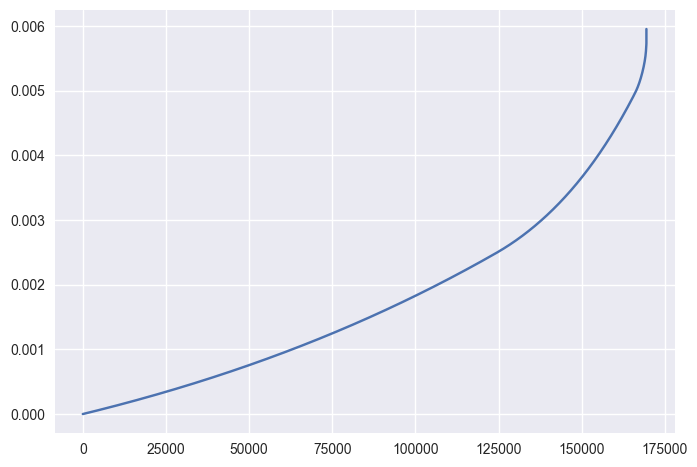

In [11]:
plt.plot(np.cumsum(contributions))

In [12]:
import matplotlib.pyplot as plt

def draw_square(x_min, y_min, x_max, y_max):
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='blue')

def plot_regions(regions):
    for region in regions:
        x_min, y_min = region[0]
        x_max, y_max = region[1]
        draw_square(x_min, y_min, x_max, y_max)
    plt.xlabel('State[0]')
    plt.ylabel('State[1]')
    plt.grid(True)
    plt.axis('equal')  # Set equal aspect ratio
    plt.show()

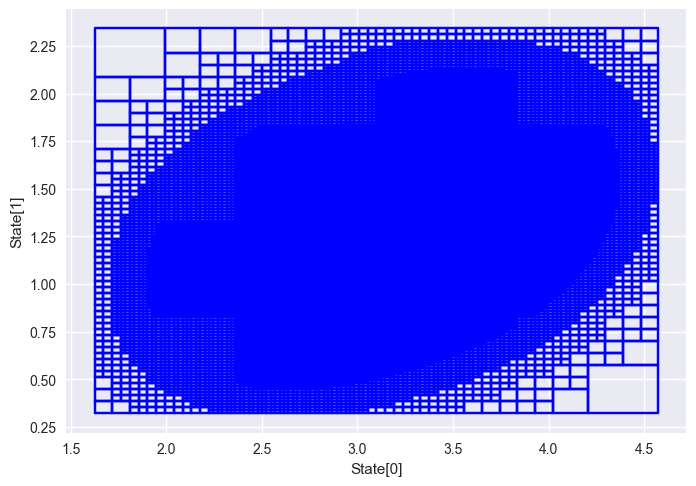

In [13]:
plot_regions(regions)

##### Compare hitting probabilities

C:\Users\efigueiredomot\AppData\Local\Temp\ipykernel_3584\1569244730.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


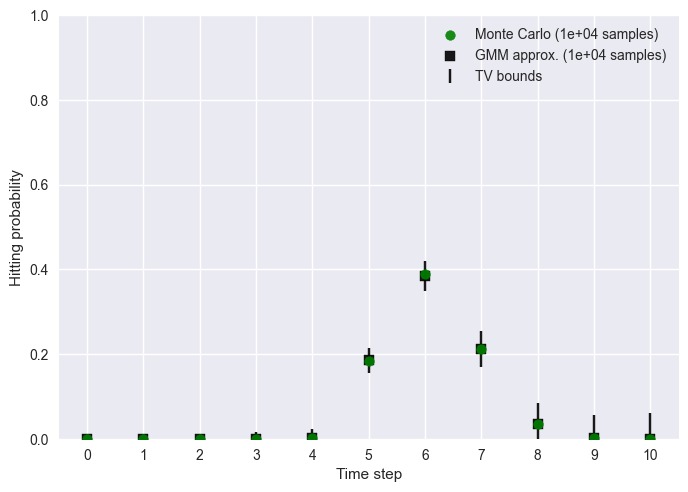

In [14]:
#Compute TV bounds
tv_bounds_cumul = np.cumsum(tv_bounds)

plt.style.use("seaborn")

# Plotting
plt.scatter(range(len(mc_hitting_proba)), mc_hitting_proba, color='green', alpha = 0.9, label = f'Monte Carlo ({n_simulations:.0e} samples)', zorder=3)
plt.scatter(range(len(gmm_hitting_proba)), gmm_hitting_proba, color='black', alpha = 0.9, marker='s', label = f'GMM approx. ({n_samples:.0e} samples)', zorder=2)

# Adding error bars for gmm_probas
plt.errorbar(range(len(gmm_hitting_proba)), gmm_hitting_proba, yerr = tv_bounds_cumul, fmt='none', color='black', alpha = 0.9, capsize=5, label='TV bounds', zorder=1)

plt.ylim(0, 1)
plt.xticks(range(len(mc_hitting_proba)))

plt.xlabel('Time step')
plt.ylabel('Hitting probability')
plt.legend()
plt.show()

##### TV bounds

In [15]:
tv_bounds_cumul

array([0.        , 0.0037431 , 0.0097095 , 0.01583655, 0.02247892,
       0.02887897, 0.03596863, 0.04243257, 0.04849985, 0.0546848 ,
       0.06063894])